## Pump it Up: Data Mining the Water Table

Challenge Summary
Technical diagram of a hand pump

Can you predict which water pumps are faulty?

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

#### Import necessary libraries and load the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load the data
train_values = pd.read_csv('../data/Training_set_values.csv')
train_labels = pd.read_csv('../data/Training_set_labels.csv')
test_values = pd.read_csv('../data/Test_set_values.csv')
submission_format = pd.read_csv('../data/SubmissionFormat.csv')

# Merge training data
train_data = pd.merge(train_values, train_labels, on='id')

print(train_data.shape)
print(test_values.shape)

(59400, 41)
(14850, 40)


In [2]:
train_values.head(5)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [3]:
train_labels.head(5)

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [4]:
test_values.head(5)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


### Explore the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

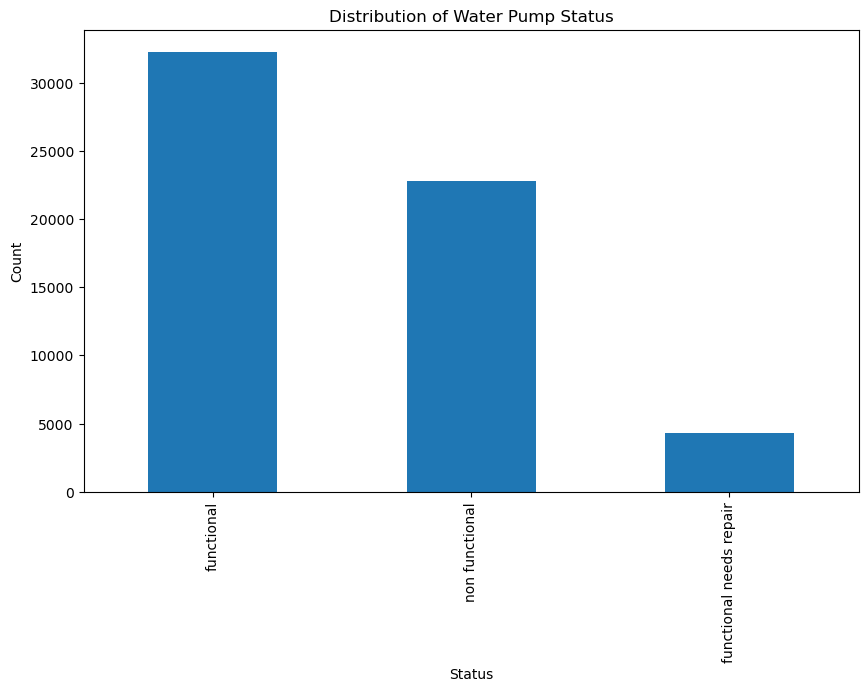

In [5]:
# Display basic information about the dataset
print(train_data.info())

# Check for missing values
print(train_data.isnull().sum())

# Display summary statistics
print(train_data.describe())

# Plot distribution of target variable
plt.figure(figsize=(10, 6))
train_data['status_group'].value_counts().plot(kind='bar')
plt.title('Distribution of Water Pump Status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

### Preprocess the data

                         precision    recall  f1-score   support

             functional       0.81      0.89      0.85      6457
functional needs repair       0.58      0.35      0.44       851
         non functional       0.84      0.78      0.81      4572

               accuracy                           0.81     11880
              macro avg       0.74      0.68      0.70     11880
           weighted avg       0.81      0.81      0.81     11880



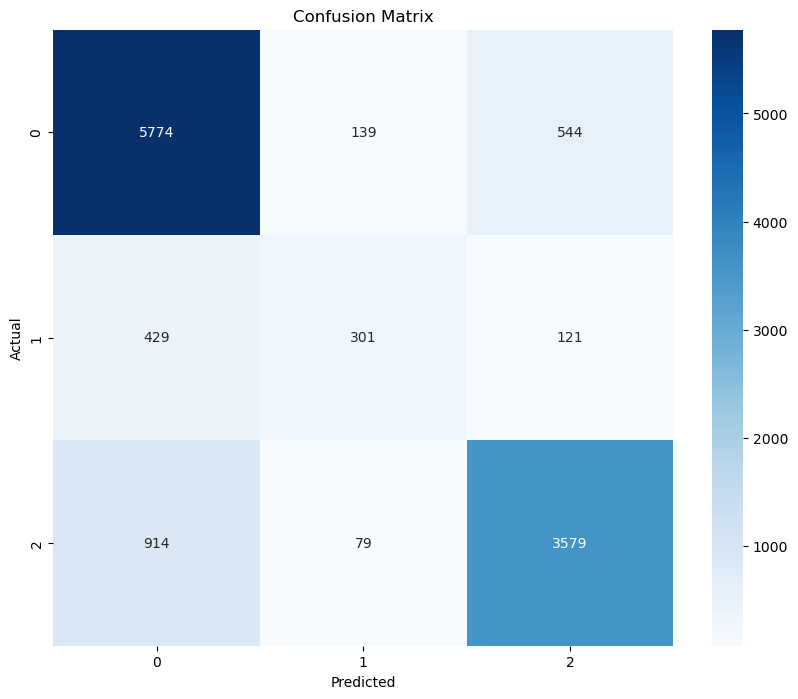

In [6]:
# Convert all categorical columns to string type
train_data = train_data.astype({col: 'str' for col in train_data.select_dtypes(include=['object', 'bool']).columns})

# Identify numeric and categorical columns
numeric_features = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features = [col for col in numeric_features if col not in ['id', 'status_group']]

categorical_features = train_data.select_dtypes(include=['object']).columns.tolist()
categorical_features = [col for col in categorical_features if col not in ['id', 'status_group']]

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Prepare the full pipeline with the model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

# Prepare the data
X = train_data.drop(['id', 'status_group'], axis=1)
y = train_data['status_group']

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Make predictions on validation set
y_pred = model.predict(X_val)

# Print classification report
print(classification_report(y_val, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [7]:
X_train.head(5)

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
3607,50.0,2013-02-27,Dmdd,2092,DMDD,35.426020,-4.227446,Narmo,0,Internal,...,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
50870,0.0,2011-03-17,Cmsr,0,Gove,35.510074,-5.724555,Lukali,0,Internal,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
20413,0.0,2011-07-10,Kkkt,0,KKKT,32.499866,-9.081222,Mahakama,0,Lake Rukwa,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other
52806,0.0,2011-04-12,nan,0,nan,34.060484,-8.830208,Shule Ya Msingi Chosi A,0,Rufiji,...,monthly,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
50091,300.0,2011-04-05,Ki,1023,Ki,37.032690,-6.040787,Kwa Mjowe,0,Wami / Ruvu,...,on failure,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other


### Train the model and evaluate

                         precision    recall  f1-score   support

             functional       0.81      0.89      0.85      6457
functional needs repair       0.58      0.35      0.44       851
         non functional       0.84      0.78      0.81      4572

               accuracy                           0.81     11880
              macro avg       0.74      0.68      0.70     11880
           weighted avg       0.81      0.81      0.81     11880



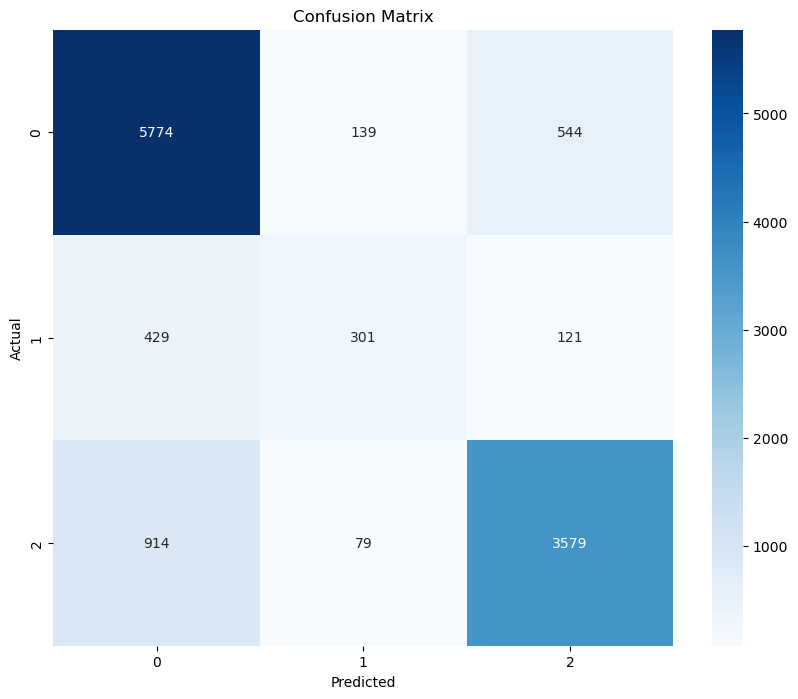

In [8]:
# Fit the model
model.fit(X_train, y_train)

# Make predictions on validation set
y_pred = model.predict(X_val)

# Print classification report
print(classification_report(y_val, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Make predictions on the test set and create submission file

In [9]:
# Prepare test data
X_test = test_values.drop('id', axis=1)

# Make predictions
test_predictions = model.predict(X_test)

# Create submission dataframe
submission = pd.DataFrame({
    'id': test_values['id'],
    'status_group': test_predictions
})

# Save to CSV
submission.to_csv('submission.csv', index=False)
print("Submission file created successfully!")

Submission file created successfully!


Feature importance analysis

Feature ranking:
1. num__longitude (0.039805)
2. num__latitude (0.039679)
3. num__gps_height (0.025720)
4. cat__quantity_dry (0.025701)
5. cat__quantity_group_dry (0.024644)
6. num__construction_year (0.018647)
7. num__population (0.018174)
8. cat__waterpoint_type_other (0.012601)
9. cat__quantity_group_enough (0.011052)
10. cat__quantity_enough (0.010836)
11. num__amount_tsh (0.008476)
12. cat__extraction_type_group_other (0.008217)
13. cat__waterpoint_type_group_other (0.008187)
14. num__district_code (0.007475)
15. cat__extraction_type_other (0.007453)
16. cat__extraction_type_class_other (0.006169)
17. cat__payment_never pay (0.005969)
18. num__region_code (0.005801)
19. cat__quantity_insufficient (0.005594)
20. cat__waterpoint_type_communal standpipe (0.005575)
21. cat__quantity_group_insufficient (0.005572)
22. cat__payment_type_never pay (0.005300)
23. cat__waterpoint_type_group_hand pump (0.004681)
24. cat__funder_Government Of Tanzania (0.004273)
25. cat__extraction_type_class

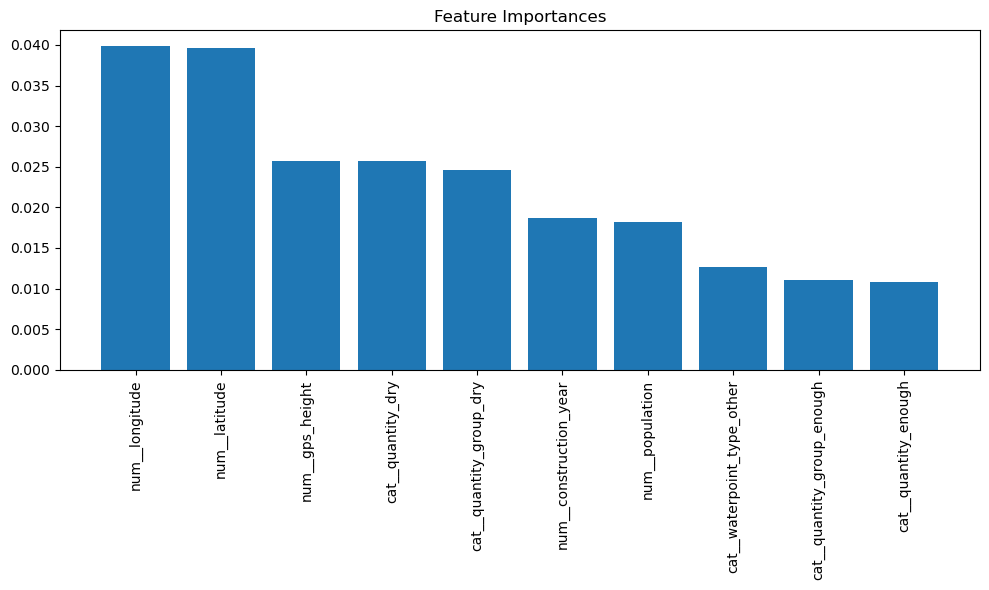

In [10]:
# Get feature importances
importances = model.named_steps['classifier'].feature_importances_
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(10), importances[indices][:10])
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=90)
plt.tight_layout()
plt.show()